# Week 2

## Improved plot

- Only consider the mean of "active" simulations
- Also plot deterministic solution
- Only interpolate to next event

In [11]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.interpolate import interp1d
from tqdm import tqdm
import scienceplots

plt.style.use(['science','ieee'])
plt.rcParams['font.size'] = 13

from bp_models.gillespie import run_ensemble_sir

number_of_sims = 5000
N = 500
beta = 0.3
mu = 0.1


ts, Is, R_finals, max_t = run_ensemble_sir(N, beta, mu, number_of_sims)

100%|██████████| 5000/5000 [00:00<00:00, 11992.32it/s]


In [2]:
from scipy.integrate import solve_ivp

def rhs(t, y):
    S = y[0]
    I = y[1]
    R = y[2]
    return [-beta*I*S/N, beta*I*S/N - mu*I, mu*I]

sol = solve_ivp(rhs, t_span=(0, max_t), y0=[N-1, 1, 0], rtol=1e-9)

0it [00:00, ?it/s]

500it [00:05, 95.19it/s] 
/tmp/ipykernel_2832191/1725226475.py:11: RuntimeWarning: Mean of empty slice
  ax.plot(plot_t, np.nanmean(padded_data, axis=0), 'k', linewidth=2, label="Mean")
/home/jakeb/development/Branching-Process-Models/venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/tmp/ipykernel_2832191/1725226475.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig("figures/gillespie.pdf")
/home/jakeb/development/Branching-Process-Models/venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/jakeb/development/Branching-Process-Models/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **

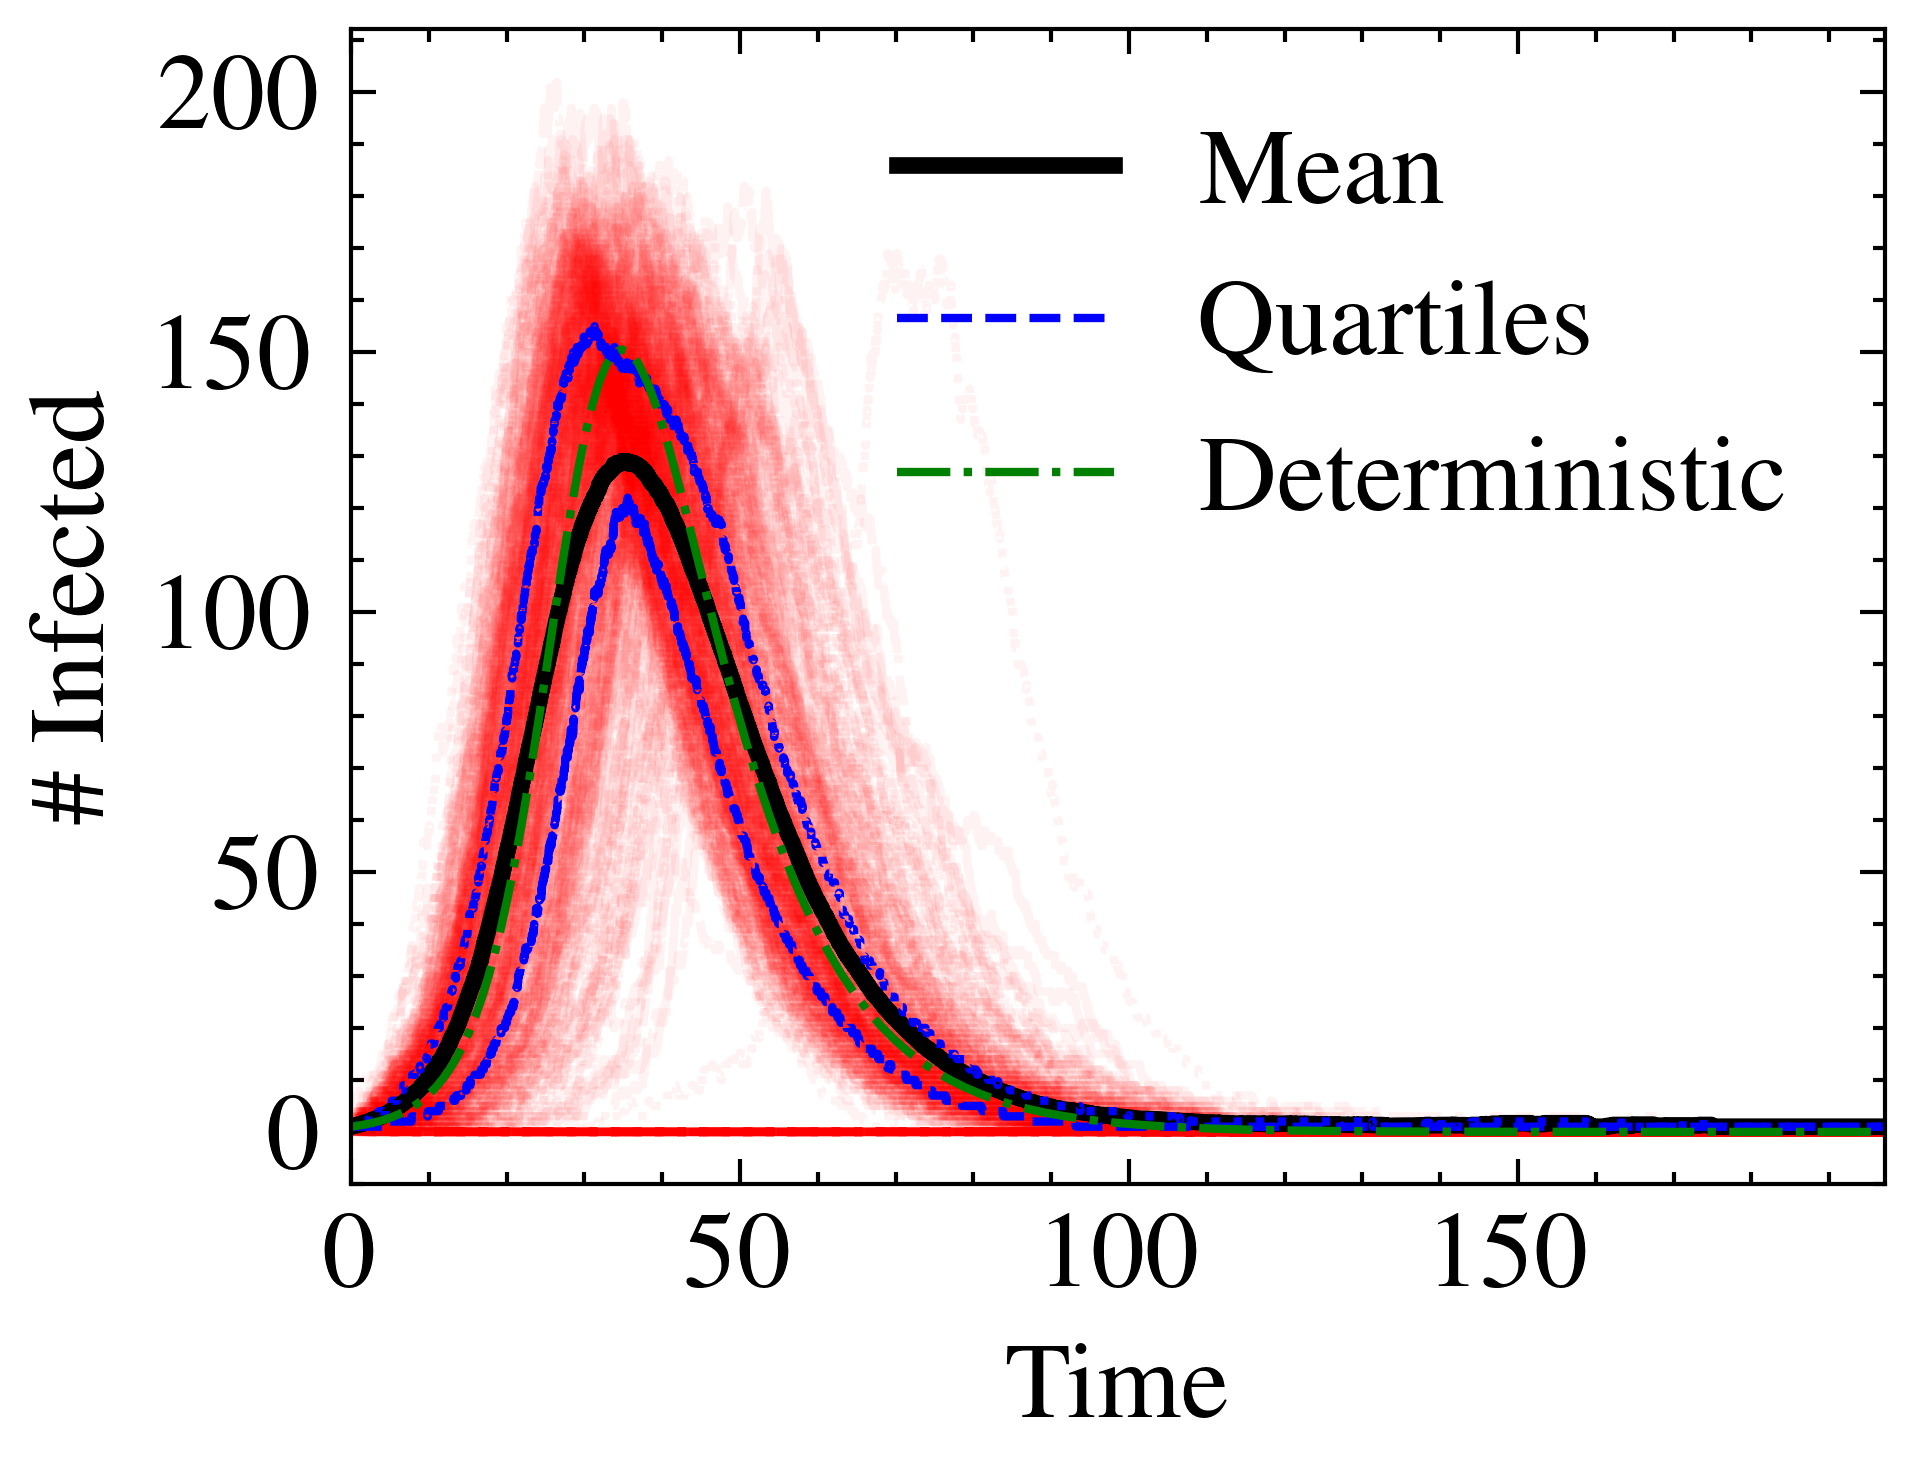

In [3]:
fig, ax = plt.subplots()
plot_t = np.linspace(0, max_t, num=int(max_t)*1000)
padded_data = np.empty((number_of_sims, plot_t.size))
for i, (t, s) in tqdm(enumerate(zip(ts, Is))):
    padded = interp1d(t, s, bounds_error=False, fill_value=0, kind='previous')(plot_t)
    padded_data[i,:] = padded

padded_data = np.asarray(padded_data)
ax.plot(plot_t, padded_data.T, 'r', alpha=0.05)
padded_data[padded_data == 0] = np.nan
ax.plot(plot_t, np.nanmean(padded_data, axis=0), 'k', linewidth=2, label="Mean")
ax.plot(plot_t, np.nanquantile(padded_data, 0.25, axis=0), 'b', linewidth=1, label="Quartiles")
ax.plot(plot_t, np.nanquantile(padded_data, 0.75, axis=0), 'b', linewidth=1, label="_nolegend_")
ax.plot(sol.t, sol.y[1,:], label="Deterministic")

ax.legend()

ax.set_xlabel("Time")
ax.set_ylabel("\# Infected")
ax.set_xlim([0, max_t])
fig.savefig("figures/gillespie.pdf")

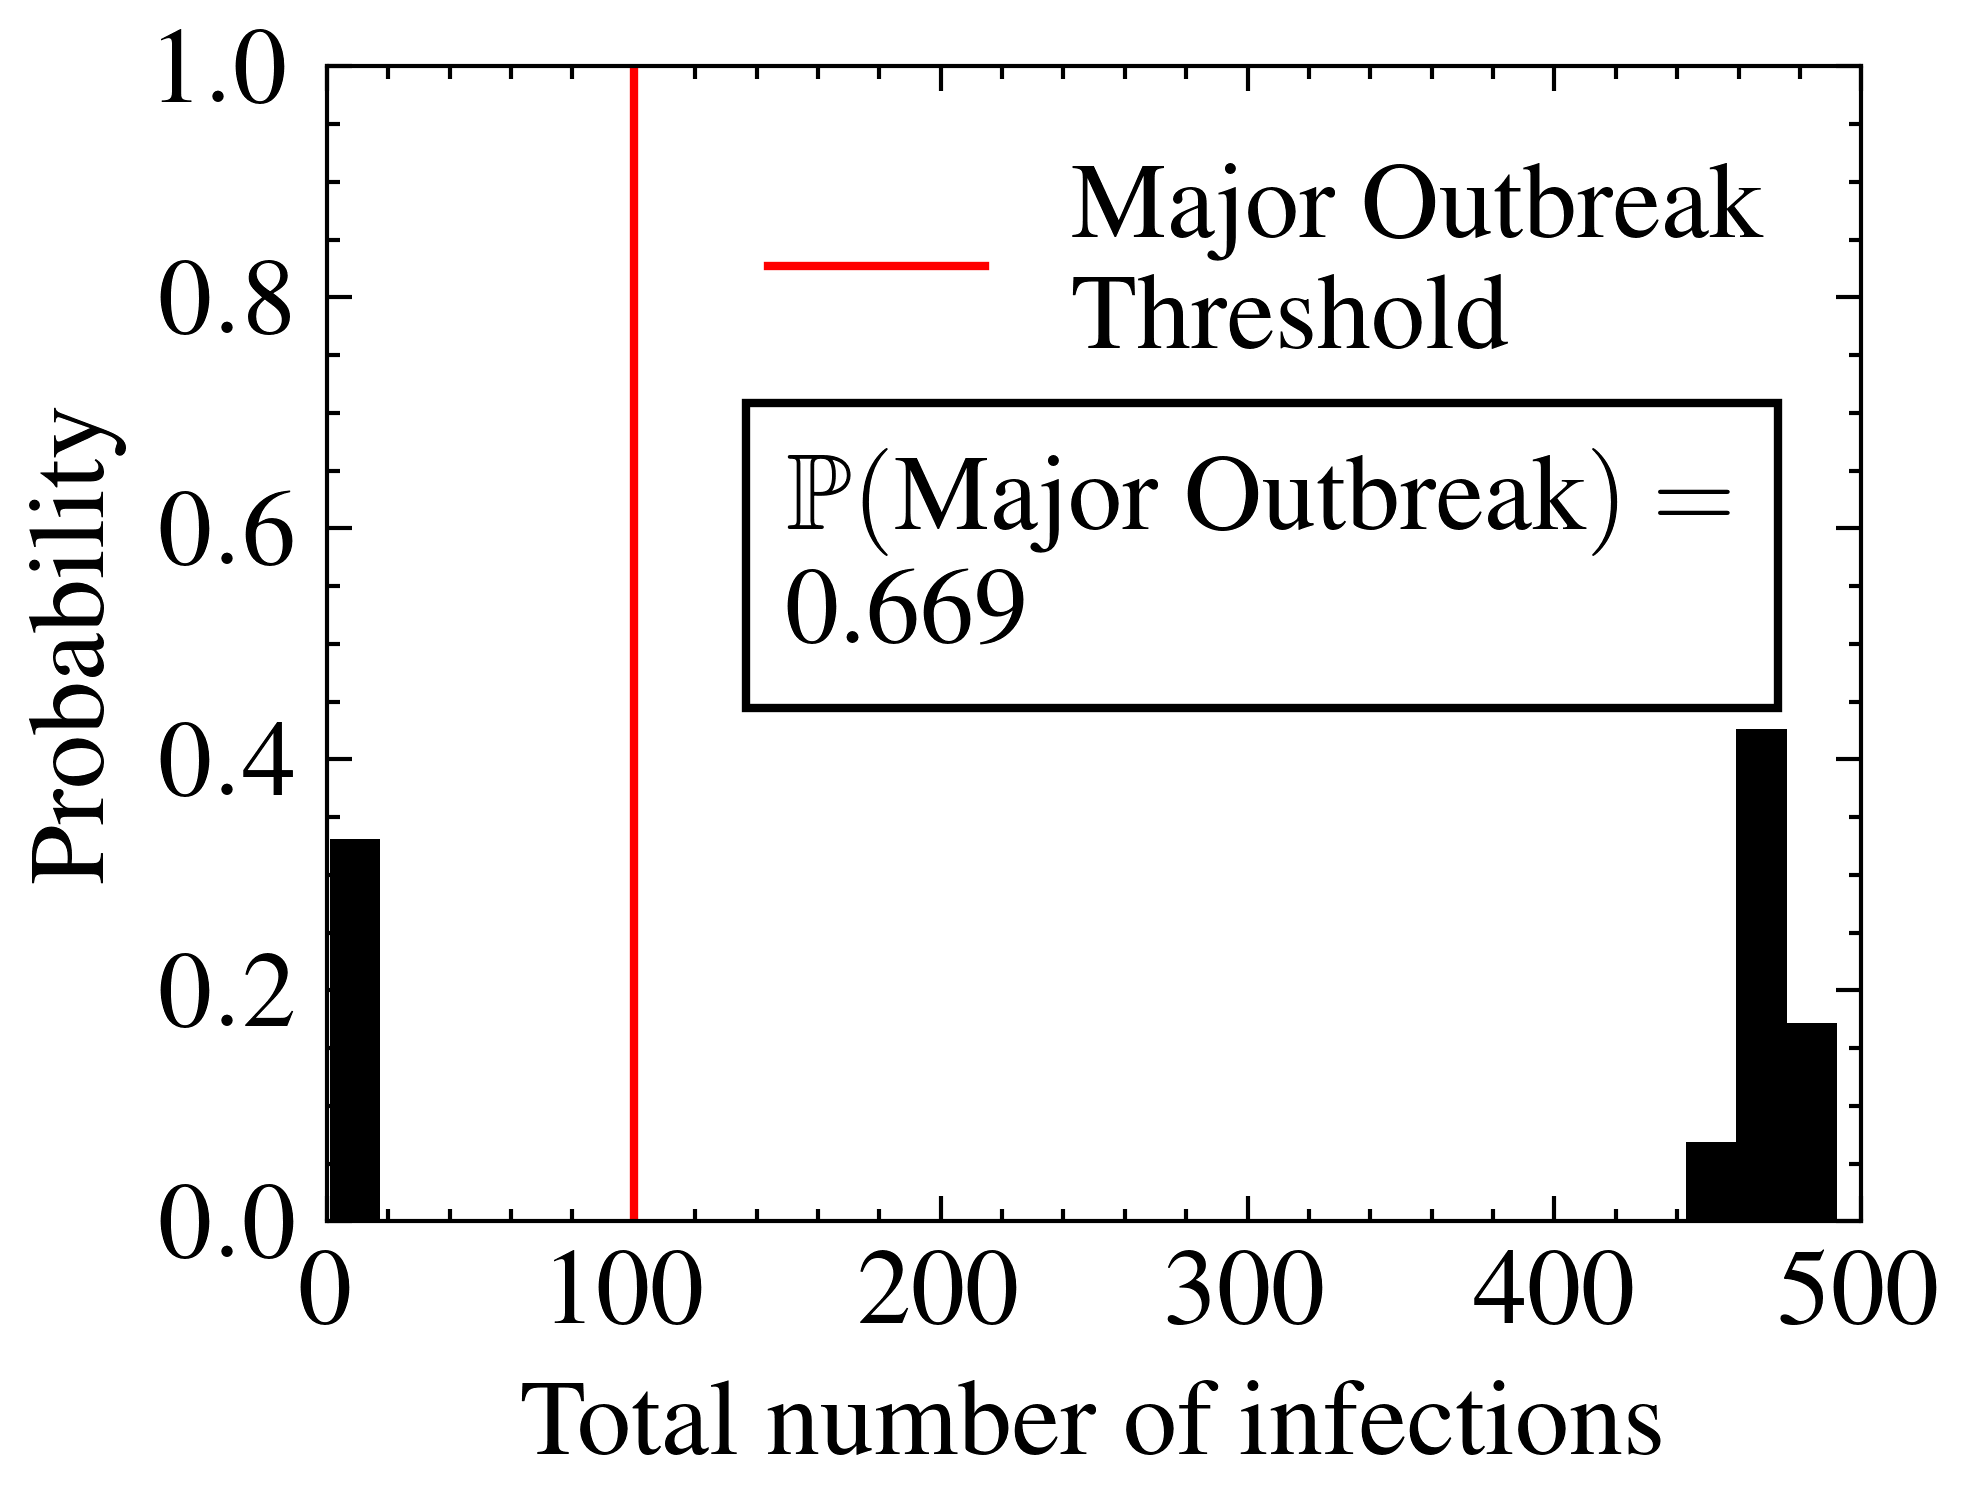

In [12]:

fig, ax = plt.subplots()
R_finals = np.asarray(R_finals)

ax.hist(R_finals, bins=30, weights=np.ones_like(R_finals)/len(R_finals))
ax.plot(2*[N*0.2],[0,1], 'r-', label="Major Outbreak\n Threshold")
ax.text(150,0.5, r"$\mathbb{P}(\text{Major Outbreak})=$"+"\n"+str(np.sum(R_finals/N > 0.2)/number_of_sims), bbox=dict(facecolor='none', edgecolor='black', pad=5.0))
ax.set_ylabel("Probability")
ax.set_xlabel("Total number of infections")
ax.set_xlim([0, N])
ax.set_ylim([0, 1])
ax.set_xticks(100*np.arange(0,6))
ax.legend()
plt.savefig("figures/hist.pdf")